In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cluster import KMeans

dataset = fetch_olivetti_faces()

In [3]:
dataset.data.shape, dataset.target.shape, dataset.images.shape

((400, 4096), (400,), (400, 64, 64))

In [22]:
X, y = dataset.data, dataset.target
sss = StratifiedShuffleSplit(n_splits=1,
                             test_size=0.1,
                             random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

In [110]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, set(y_train) == set(y_test), list(set(y_train)) == list(range(40))

((360, 4096), (360,), (40, 4096), (40,), True, True)

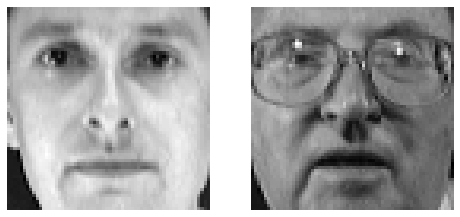

In [24]:
image1 = X_train[0].reshape(64, 64)
image2 = X_train[1].reshape(64, 64)
plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.imshow(image1, cmap='gist_gray')
plt.axis('off')

plt.subplot(122)
plt.imshow(image2, cmap='gist_gray')
plt.axis('off')

plt.show()

In [28]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

In [29]:
y = y.astype(np.uint8)

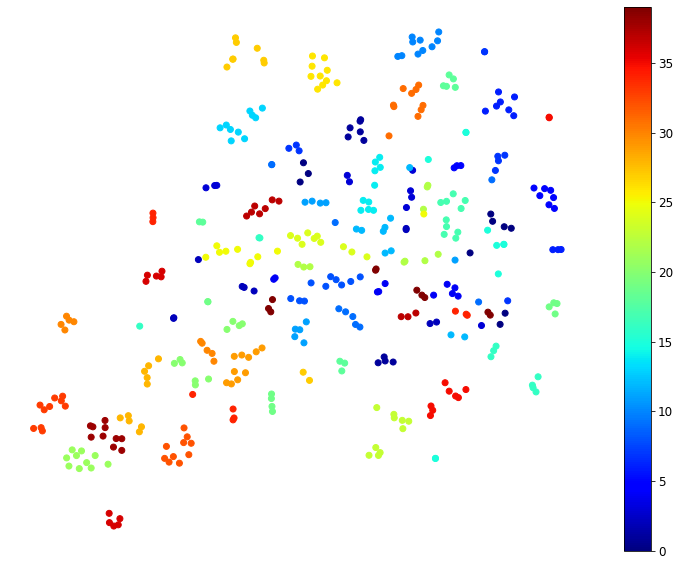

In [30]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1],
            c=y,
            cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

In [32]:
X.min(), X.max()

(0.0, 1.0)

In [57]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_faces(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    # ! No scaling !
    X_normalized = X
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    faces = np.unique(y)
    ax = plt.gcf().gca()  # get current axes in current figure
    for face in faces:
        plt.scatter(X_normalized[y == face, 0], X_normalized[y == face, 1], c=[cmap(face / 40)], s=220)
        if images is not None:
            image = images[y == face][0].reshape(64,64)
            image_coord = X_normalized[y == face][0]
            imagebox = AnnotationBbox(OffsetImage(image, cmap="gist_gray"), image_coord)
            ax.add_artist(imagebox)
    plt.axis("off")
    '''
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(64, 64)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="gist_gray"), image_coord)
                ax.add_artist(imagebox)
    '''

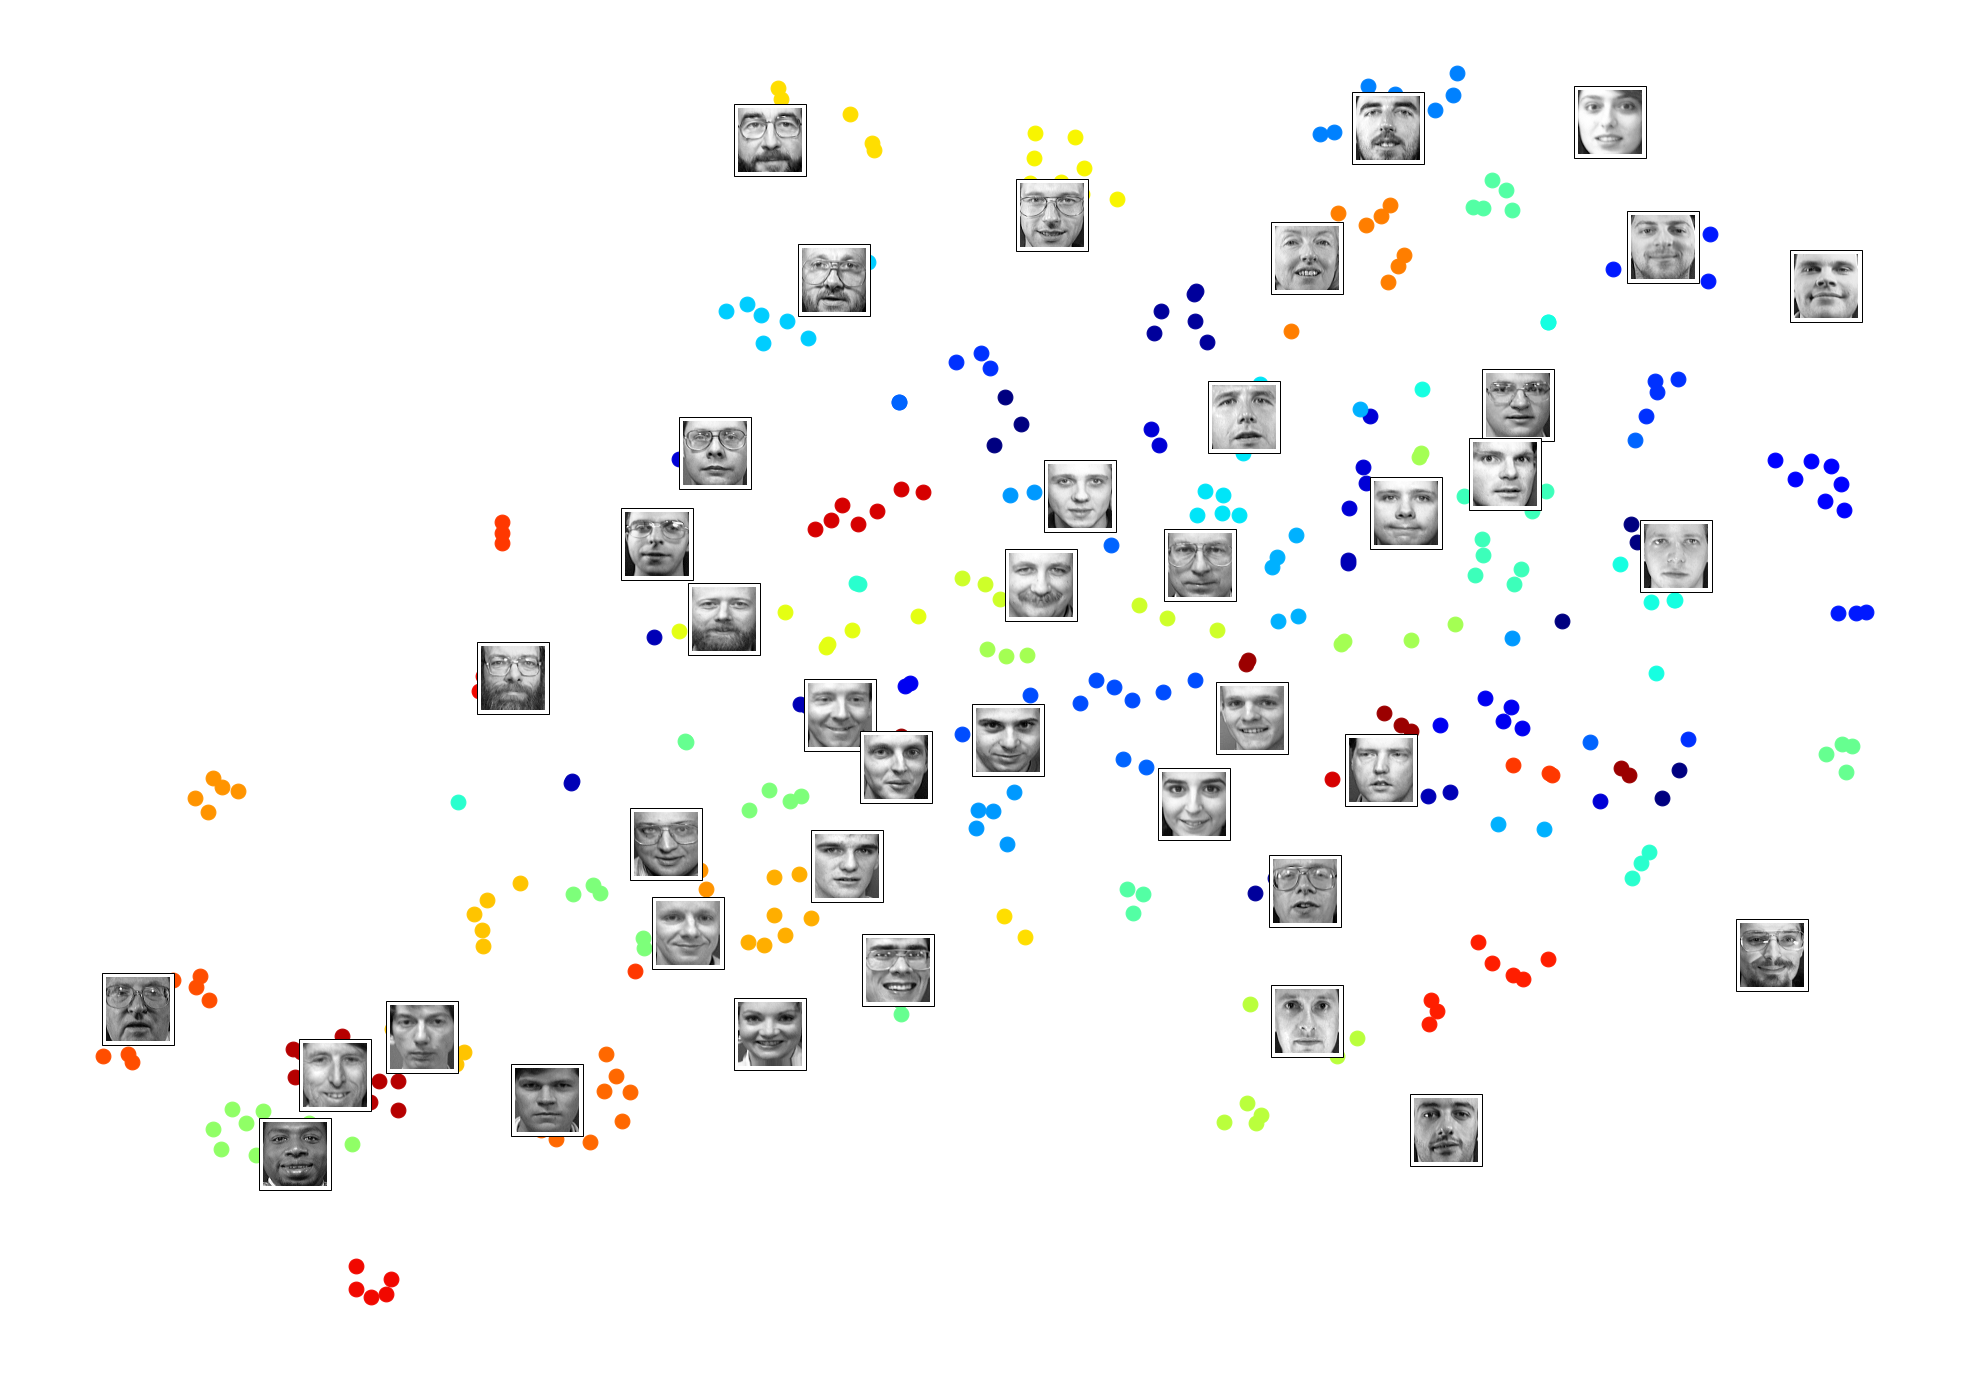

In [58]:
plot_faces(X_reduced, y, min_distance=4.5, images=X, figsize=(35, 25))

In [59]:
%%time
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(40, 80)]
inertias = [model.inertia_ for model in kmeans_per_k]

CPU times: user 11min 30s, sys: 23.8 s, total: 11min 54s
Wall time: 7min 22s


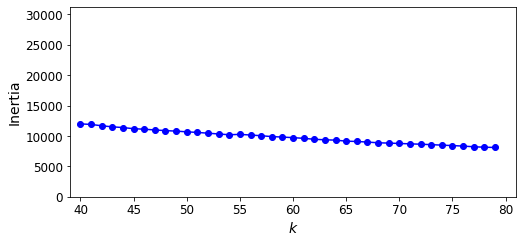

In [63]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(40, 80), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
#plt.annotate('Elbow',
#             xy=(4, inertias[3]),
#             xytext=(0.55, 0.55),
#             textcoords='figure fraction',
#             fontsize=16,
#             arrowprops=dict(facecolor='black', shrink=0.1)
#            )
plt.axis([39, 81, 0, 31300])
plt.show()

In [64]:
from sklearn.metrics import silhouette_score

In [67]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k]

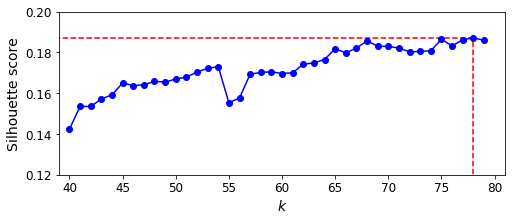

In [99]:
max_silhouette_score = max(silhouette_scores)
idx_max_sil_score = silhouette_scores.index(max_silhouette_score) + 40

plt.figure(figsize=(8, 3))
plt.plot([0, idx_max_sil_score],[max_silhouette_score, max_silhouette_score], 'r--')
plt.plot([idx_max_sil_score, idx_max_sil_score],[0, max_silhouette_score], 'r--')

plt.plot(range(40, 80), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
#plt.axhline(y=max(silhouette_scores), color="red", linestyle='--', linewidth=3)
plt.axis([39, 81, 0.12, 0.2])
plt.show()

In [100]:
idx_max_sil_score,max_silhouette_score

(78, 0.18719523)

In [101]:
kmeans_k78 = KMeans(n_clusters=78, random_state=42)
kmeans_k78.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=78, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [113]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(random_state=42)
sgd.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [114]:
from sklearn.metrics import accuracy_score

In [115]:
y_pred1 = sgd.predict(X_test)
accuracy_score(y_test, y_pred1)

0.75

In [116]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

y_pred2 = lr.predict(X_test)
accuracy_score(y_test, y_pred2)

/home/biowar1337/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.975

In [162]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps=[
    ("kmeans", KMeans(n_clusters=90,
                      n_init=50,
                      random_state=42)),
    ("logistic_regression", LogisticRegression())
], verbose=True)

pipeline.fit(X_train, y_train)
y_pred3 = pipeline.predict(X_test)
accuracy_score(y_test, y_pred3)

[Pipeline] ............ (step 1 of 2) Processing kmeans, total= 1.3min
[Pipeline]  (step 2 of 2) Processing logistic_regression, total=   0.4s


/home/biowar1337/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.85